# Minimum Weighted Maximum Matching

#### 編集者: 森雅也

問題：  
会社に属する新卒社員N人に対し，それぞれの希望順位に基づき2人1組のマッチングを行いたい(グループ数：N/2)．  

解法：  
仮に6人(A,B,C,D,E,F)がいるとした時，何かしらの情報を基にそれぞれの希望順位を書き出してもらう(今回は3位まで)．  
そして，希望順位を基にそれぞれに点数を与える(1位:1pt,2位:2pt,3位:3pt,4位~:10pt)  
- A, 1位:C 2位:D 3位:F
- B, 1位:E 2位:F 3位:C
- C, 1位:B 2位:E 3位:D
- D, 1位:F 2位:A 3位:E
- E, 1位:A 2位:F 3位:C
- F, 1位:B 2位:D 3位:A 

続いて，上記の希望順位に基づき，[重み付き無向グラフ](https://algo-logic.info/graph/)を構築する．  
この時の重みは，それぞれの希望順位による点数の総和とする．  
例えば，A→Cは1位なので1pt，C→Aは圏外なので10pt，したがってA-C間の辺の重みは11ptである．  
そうすると，これらは次のグラフのように表現することが可能である．  
<img src="./img/graph.jpg" width="50%">

したがって，全員の希望をいい感じに考慮しつつ問題で挙げたマッチングを行うには  
- 必ず誰かしらとペアになる(最大マッチング)  
- その際に辺の重みの総和を最小にする(最小費用)  

を達成する必要がある(本当はばらつきも考慮すべきだが，今回は簡略化のため除く)．

そのため今回は，『最小重み最大マッチング(Minimum Weighted Maximum Matching; mwmm)』を用いることで，
これらの解決を試みる．  
以下にソースコードを記述する．

## 参考資料

 - [マッチング問題とその変形に対するアルゴリズム](https://scmopt.github.io/opt100/30matching.html)  
- [python: NetworkX による無向/有向グラフの読み込みと可視化](https://www.letsopt.com/entry/2019/10/22/214535)  

# ソースコード

In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

data = pd.read_csv("./input/example.csv")
data

,タイムスタンプ,名前を入力してください(例: 森雅也),第1希望,第2希望,第3希望
0,2022/04/03 4:54:11 午後 GMT+9,A,C,D,F
1,2022/04/03 4:54:29 午後 GMT+9,B,E,F,C
2,2022/04/03 4:54:46 午後 GMT+9,C,B,E,D
3,2022/04/03 4:55:03 午後 GMT+9,D,F,A,E
4,2022/04/03 4:55:25 午後 GMT+9,E,A,F,C
5,2022/04/03 4:55:36 午後 GMT+9,F,B,D,A


## 前処理

In [33]:
# 第1希望のscore
NO1_SCORE = 1
# 第2希望のscore
NO2_SCORE = 2
# 第3希望のscore
NO3_SCORE = 3
# 第4希望以降のscore
OTHER_SCORE = 10

In [34]:
## タイムスタンプの削除
data_wo_ts = data.drop(['タイムスタンプ'], axis=1)

In [35]:
## nx.read_weighted_edgelist用にフォーマットを整える
# 全体集合
uni_set = data_wo_ts['名前を入力してください(例: 森雅也)'].values
# 出力用の空配列(頂点，重み)の作成
vertex, weight = [], []
# 希望順位を基にweightを算出する
def create_graph(sub, comp, score):
    vertex.append([sub,comp])
    weight.append(score)

for i, sub in enumerate(uni_set):
    for comp in uni_set:
        # 対象者と比較が同一人物でないか
        if sub != comp:
            # 第1希望と比較対象が一致しているか
            if data_wo_ts['第1希望'][i] == comp:
                create_graph(sub, comp, NO1_SCORE)
            elif data_wo_ts['第2希望'][i] == comp:
                create_graph(sub, comp, NO2_SCORE)
            elif data_wo_ts['第3希望'][i] == comp:
                create_graph(sub, comp, NO3_SCORE)
            else:
                create_graph(sub, comp, OTHER_SCORE)

# 矢印を無向に変換する
vertex_sorted = [sorted(S) for i, S in enumerate(vertex)]
# DataFrameに格納する
df_graph = pd.DataFrame(vertex_sorted, columns=['頂点1','頂点2'])
df_graph = pd.concat([df_graph, pd.Series(weight, name='weight').T], axis=1)
# 重み算出後の無向グラフ
w_graph = df_graph.groupby(['頂点1','頂点2'], as_index=False).sum()

# txtで保存する
w_graph.to_csv('./input/w_graph.txt', header=None, index=None, sep=' ')

In [36]:
w_graph

,頂点1,頂点2,weight
0,A,B,20
1,A,C,11
2,A,D,4
3,A,E,11
4,A,F,6
5,B,C,4
6,B,D,20
7,B,E,11
8,B,F,3
9,C,D,13


## MVMMの適用

In [37]:
# 無向グラフの作成
G = nx.Graph()

# 重み付きのファイルの読み込み
G = nx.read_weighted_edgelist('./input/w_graph.txt')#, nodetype=int

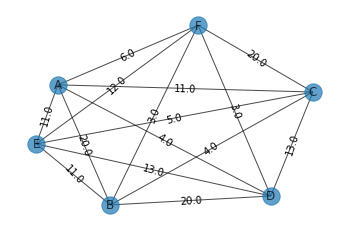

In [40]:
# グラフの描画
pos = nx.spring_layout(G)
edge_labels = {(i, j): w['weight'] for i, j, w in G.edges(data=True)}
nx.draw_networkx_edge_labels(G,pos, edge_labels=edge_labels)
nx.draw_networkx(G, pos, with_labels=True, alpha=0.7)

# 表示
plt.axis("off")
plt.show()

In [41]:
# 計算
edges = nx.min_weight_matching(G)
edges

{('A', 'D'), ('C', 'E'), ('F', 'B')}

In [31]:
# 計算
edges = nx.min_weight_matching(G)
edges

{('中村哲也', '石川翔太'), ('佐藤隆司', '山本孝一'), ('高橋文彦', '石川修')}